We experimented with several end-to-end pipelines—first training a dual-output neural network on compressed categorical+quantitative features, then refining it with oversampling and per-task threshold tuning, which yielded a weighted F1 around 0.60 on our hold-out set. Ensembling that NN with a LightGBM stack boosted our test accuracy on the leaderboard ~0.74. Finally, we tried augmenting the model with raw functional connectome matrices (36×36 Pearson features), but that extra high-dimensional input actually nudged performance down slightly to ~0.73. This was the reason for doing the modeling without connectome data in the first place. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble         import RandomForestClassifier
from sklearn.multioutput      import MultiOutputClassifier
from sklearn.metrics          import f1_score
from tensorflow.keras.models  import Model
from tensorflow.keras.layers  import Input, Dense
from tensorflow.keras.optimizers import Adam

# ----------------------
# STEP 1: LOAD DATA
# ----------------------
train_cat = pd.read_excel(
    "widsdatathon2025_/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx",
    dtype={"participant_id": str}
)
train_quant = pd.read_excel(
    "widsdatathon2025_/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx",
    dtype={"participant_id": str}
)
train_sol = pd.read_excel(
    "widsdatathon2025_/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx",
    dtype={"participant_id": str}
)

test_cat = pd.read_excel(
    "widsdatathon2025_/TEST/TEST_CATEGORICAL.xlsx",
    dtype={"participant_id": str}
)
test_quant = pd.read_excel(
    "widsdatathon2025_/TEST/TEST_QUANTITATIVE_METADATA.xlsx",
    dtype={"participant_id": str}
)

print("STEP 1: Data loaded")
print(f"  train_cat: {train_cat.shape}")
print(f"  train_quant: {train_quant.shape}")
print(f"  train_sol: {train_sol.shape}")
print(f"  test_cat: {test_cat.shape}")
print(f"  test_quant: {test_quant.shape}\n")


STEP 1: Data loaded
  train_cat: (1213, 10)
  train_quant: (1213, 19)
  train_sol: (1213, 3)
  test_cat: (304, 10)
  test_quant: (304, 19)



In [33]:

# ----------------------
# STEP 2: HANDLE MISSING CATEGORICALS
# ----------------------
train_cat.fillna('Unknown', inplace=True)
test_cat.fillna('Unknown', inplace=True)

print("STEP 2: Missing categoricals filled with 'Unknown'")
print(train_cat.isnull().sum().head())
print(test_cat.isnull().sum().head(), "\n")


STEP 2: Missing categoricals filled with 'Unknown'
participant_id                      0
Basic_Demos_Enroll_Year             0
Basic_Demos_Study_Site              0
PreInt_Demos_Fam_Child_Ethnicity    0
PreInt_Demos_Fam_Child_Race         0
dtype: int64
participant_id                      0
Basic_Demos_Enroll_Year             0
Basic_Demos_Study_Site              0
PreInt_Demos_Fam_Child_Ethnicity    0
PreInt_Demos_Fam_Child_Race         0
dtype: int64 



C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_32776\1102729600.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_cat.fillna('Unknown', inplace=True)
C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_32776\1102729600.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_cat.fillna('Unknown', inplace=True)


In [34]:

# ----------------------
# STEP 3: IMPUTE QUANTITATIVE
# ----------------------
def report_nulls(df, name):
    nulls = df.isnull().sum()
    print(f"  {name} null counts:\n{nulls[nulls>0]}\n")

print("Before imputation:")
report_nulls(train_quant, 'train_quant')
report_nulls(test_quant,  'test_quant')

# Impute TRAIN quantitative missing values
# Age: mean
train_quant['MRI_Track_Age_at_Scan'] = train_quant['MRI_Track_Age_at_Scan']\
    .fillna(train_quant['MRI_Track_Age_at_Scan'].mean())
# Survey cols: median
train_survey_cols = [c for c in train_quant.columns if 'APQ' in c or 'SDQ' in c]
for c in train_survey_cols:
    train_quant[c] = train_quant[c].fillna(train_quant[c].median())
# EHQ: median
if 'EHQ_EHQ_Total' in train_quant:
    train_quant['EHQ_EHQ_Total'] = train_quant['EHQ_EHQ_Total'].fillna(train_quant['EHQ_EHQ_Total'].median())
# ColorVision: mode
if 'ColorVision_CV_Score' in train_quant:
    train_quant['ColorVision_CV_Score'] = train_quant['ColorVision_CV_Score'].fillna(train_quant['ColorVision_CV_Score'].mode()[0])

# Impute TEST quantitative missing values
# Age (if any): mean
if 'MRI_Track_Age_at_Scan' in test_quant:
    test_quant['MRI_Track_Age_at_Scan'] = test_quant['MRI_Track_Age_at_Scan'].fillna(train_quant['MRI_Track_Age_at_Scan'].mean())
# Survey cols: median
test_survey_cols = [c for c in test_quant.columns if 'APQ' in c or 'SDQ' in c]
for c in test_survey_cols:
    test_quant[c] = test_quant[c].fillna(test_quant[c].median())
# EHQ: median
if 'EHQ_EHQ_Total' in test_quant:
    test_quant['EHQ_EHQ_Total'] = test_quant['EHQ_EHQ_Total'].fillna(test_quant['EHQ_EHQ_Total'].median())
# ColorVision: mode
if 'ColorVision_CV_Score' in test_quant:
    test_quant['ColorVision_CV_Score'] = test_quant['ColorVision_CV_Score'].fillna(test_quant['ColorVision_CV_Score'].mode()[0])

print("After imputation:")
report_nulls(train_quant, 'train_quant')
report_nulls(test_quant,  'test_quant')


Before imputation:
  train_quant null counts:
EHQ_EHQ_Total                  13
ColorVision_CV_Score           23
APQ_P_APQ_P_CP                 12
APQ_P_APQ_P_ID                 12
APQ_P_APQ_P_INV                12
APQ_P_APQ_P_OPD                12
APQ_P_APQ_P_PM                 12
APQ_P_APQ_P_PP                 12
SDQ_SDQ_Conduct_Problems        9
SDQ_SDQ_Difficulties_Total      9
SDQ_SDQ_Emotional_Problems      9
SDQ_SDQ_Externalizing           9
SDQ_SDQ_Generating_Impact       9
SDQ_SDQ_Hyperactivity           9
SDQ_SDQ_Internalizing           9
SDQ_SDQ_Peer_Problems           9
SDQ_SDQ_Prosocial               9
MRI_Track_Age_at_Scan         360
dtype: int64

  test_quant null counts:
EHQ_EHQ_Total                  1
ColorVision_CV_Score           9
APQ_P_APQ_P_CP                15
APQ_P_APQ_P_ID                15
APQ_P_APQ_P_INV               15
APQ_P_APQ_P_OPD               15
APQ_P_APQ_P_PM                15
APQ_P_APQ_P_PP                15
SDQ_SDQ_Conduct_Problems      30
SDQ_S

In [35]:

# ----------------------
# STEP 4: ONE-HOT ENCODE CATEGORICALS
# ----------------------
cat_cols = train_cat.columns.drop('participant_id')
train_ohe = pd.get_dummies(train_cat[cat_cols], prefix_sep='=', dummy_na=False)
test_ohe = pd.get_dummies(test_cat[cat_cols], prefix_sep='=', dummy_na=False)
test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

print("STEP 4: One-hot encoded categoricals")
print(f"  train_ohe shape: {train_ohe.shape}")
print(f"  test_ohe shape:  {test_ohe.shape}\n")



STEP 4: One-hot encoded categoricals
  train_ohe shape: (1213, 61)
  test_ohe shape:  (304, 61)



In [36]:
# ----------------------
# STEP 5: REDUCE DIMENSION via TruncatedSVD
# ----------------------
n_components = min(50, train_ohe.shape[1] // 2)
svd = TruncatedSVD(n_components=n_components, random_state=42)
train_cat_enc = svd.fit_transform(train_ohe)
test_cat_enc = svd.transform(test_ohe)

print("STEP 5: SVD completed")
print(f"  n_components: {n_components}")
print(f"  explained_variance_ratio_[:5]: {svd.explained_variance_ratio_[:5]}\n")


STEP 5: SVD completed
  n_components: 30
  explained_variance_ratio_[:5]: [0.16482509 0.19263595 0.07908145 0.05400254 0.04421638]



In [37]:

# ----------------------
# STEP 6: BUILD ENCODED DATAFRAMES
# ----------------------
train_cat_enc_df = pd.DataFrame(
    train_cat_enc,
    index=train_cat['participant_id'],
    columns=[f'cat_enc_{i+1}' for i in range(n_components)]
)
test_cat_enc_df = pd.DataFrame(
    test_cat_enc,
    index=test_cat['participant_id'],
    columns=[f'cat_enc_{i+1}' for i in range(n_components)]
)

print("STEP 6: Encoded DataFrames built")
print(train_cat_enc_df.head(), "\n")


STEP 6: Encoded DataFrames built
                  cat_enc_1  cat_enc_2  cat_enc_3  cat_enc_4  cat_enc_5  \
participant_id                                                            
00aIpNTbG5uh    2019.003501   2.126897   0.522995   0.925961   0.277756   
00fV0OyyoLfw    2017.000605  -1.045663  -0.838264   0.626447   0.122614   
04X1eiS79T4B    2017.000213  -1.246797   1.384571   0.394082   0.023515   
05ocQutkURd6    2018.000151  -1.152974   0.525619  -0.497484  -0.684422   
06YUNBA9ZRLq    2018.000458  -1.188975   0.530679  -0.245653   1.085849   

                cat_enc_6  cat_enc_7  cat_enc_8  cat_enc_9  cat_enc_10  ...  \
participant_id                                                          ...   
00aIpNTbG5uh     0.681157  -0.140759   0.561153   0.196865    1.123421  ...   
00fV0OyyoLfw     0.035740   1.124043   0.161888  -0.079160   -0.637596  ...   
04X1eiS79T4B     0.834508   0.789892   0.647519   0.230703    0.345187  ...   
05ocQutkURd6    -0.285079   0.138784   0.42075

In [38]:

# ----------------------
# STEP 7: PREPARE QUANTITATIVE DATA
# ----------------------
train_quant_df = train_quant.set_index('participant_id')
test_quant_df = test_quant.set_index('participant_id')
print("STEP 7: Quantitative data indexed")
print(train_quant_df.head(), "\n")


STEP 7: Quantitative data indexed
                EHQ_EHQ_Total  ColorVision_CV_Score  APQ_P_APQ_P_CP  \
participant_id                                                        
00aIpNTbG5uh           100.00                  13.0             3.0   
00fV0OyyoLfw            92.27                  14.0             3.0   
04X1eiS79T4B            86.67                  14.0             3.0   
05ocQutkURd6            93.34                  14.0             3.0   
06YUNBA9ZRLq             0.00                  14.0             8.0   

                APQ_P_APQ_P_ID  APQ_P_APQ_P_INV  APQ_P_APQ_P_OPD  \
participant_id                                                     
00aIpNTbG5uh              15.0             44.0             14.0   
00fV0OyyoLfw              12.0             35.0             25.0   
04X1eiS79T4B              21.0             37.0             18.0   
05ocQutkURd6              11.0             42.0             15.0   
06YUNBA9ZRLq              12.0             35.0             

In [39]:

# ----------------------
# STEP 8: CONCATENATE FEATURES
# ----------------------
train_features = pd.concat([train_cat_enc_df, train_quant_df], axis=1)
test_features = pd.concat([test_cat_enc_df, test_quant_df], axis=1)

print("STEP 8: Features concatenated")
print(f"  train_features shape: {train_features.shape}")
print(f"  test_features shape:  {test_features.shape}\n")


STEP 8: Features concatenated
  train_features shape: (1213, 48)
  test_features shape:  (304, 48)



In [40]:

# ----------------------
# STEP 9: MERGE TARGETS
# ----------------------
train_targets = train_sol.set_index('participant_id')[['ADHD_Outcome','Sex_F']]
train_features = train_features.join(train_targets)

print("STEP 9: Targets merged")
print(train_features[['ADHD_Outcome','Sex_F']].head(), "\n")


STEP 9: Targets merged
                ADHD_Outcome  Sex_F
participant_id                     
00aIpNTbG5uh               1      0
00fV0OyyoLfw               1      0
04X1eiS79T4B               0      1
05ocQutkURd6               0      1
06YUNBA9ZRLq               1      0 



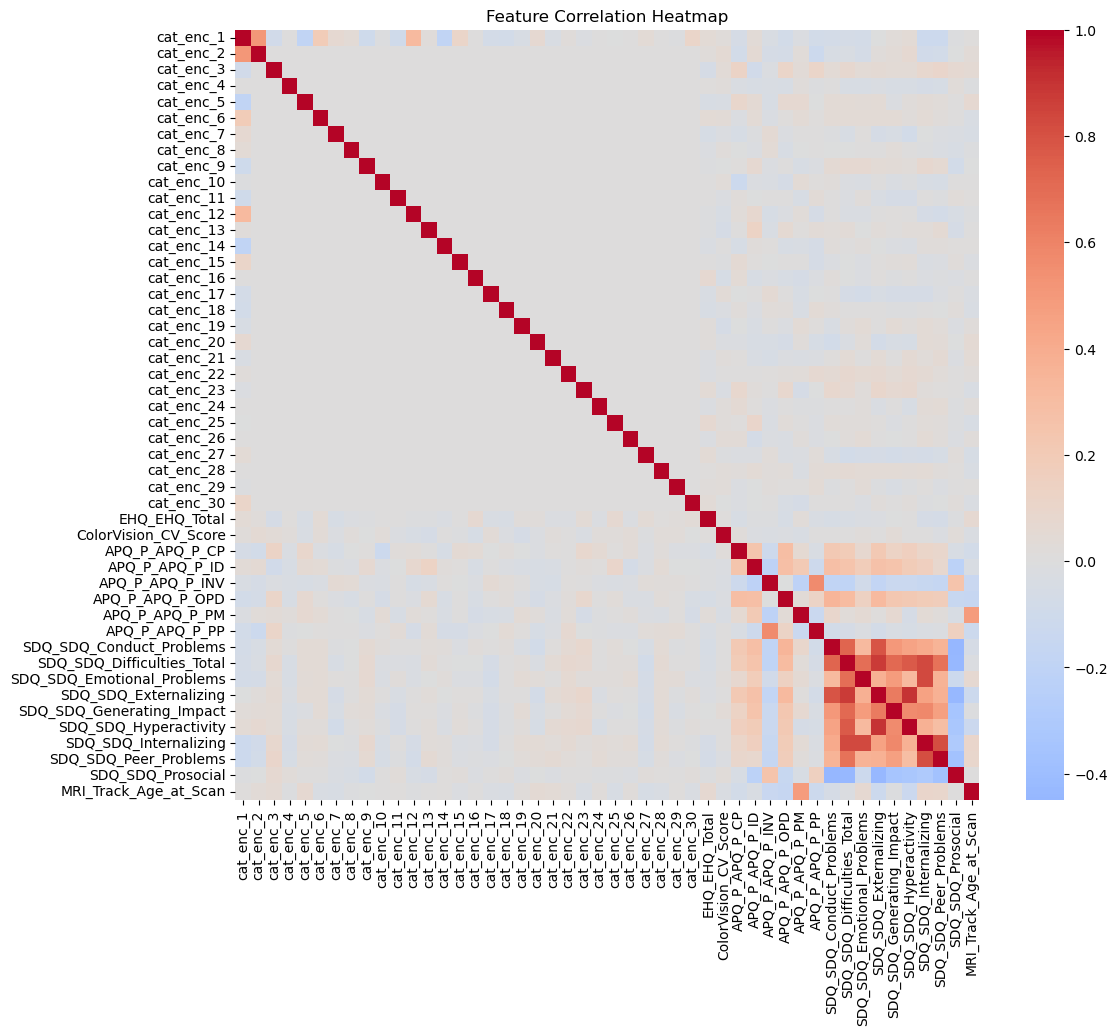

In [41]:

# ----------------------
# STEP 10: CORRELATION HEATMAP
# ----------------------
corr = train_features.drop(columns=['ADHD_Outcome','Sex_F']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()


In [42]:

# ----------------------
# STEP 11: SAVE OUTPUT
# ----------------------
train_features.to_csv('train_preprocessed.csv')
test_features.to_csv('test_preprocessed.csv')
print("STEP 11: Saved train_preprocessed.csv and test_preprocessed.csv")



STEP 11: Saved train_preprocessed.csv and test_preprocessed.csv


In [29]:

# ----------------------
# STEP 11: MODELING
# ----------------------
df = train_features.copy()
X = df.drop(columns=['ADHD_Outcome','Sex_F'])
y = df[['ADHD_Outcome','Sex_F']]

# Train-validation split (stratify on ADHD)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y['ADHD_Outcome'], random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Build NN model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train
history = model.fit(
    X_train_scaled, y_train,
    epochs=20, batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Evaluate
# Predict probabilities and convert to binary predictions
y_pred_prob = model.predict(X_val_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# F1 scores
f1_adhd = f1_score(y_val['ADHD_Outcome'], y_pred[:,0])
f1_sex  = f1_score(y_val['Sex_F'], y_pred[:,1])
weighted_f1 = (f1_adhd + f1_sex) / 2

print(f"F1 ADHD: {f1_adhd:.3f}")
print(f"F1 Sex : {f1_sex:.3f}")
print(f"Weighted F1: {weighted_f1:.3f}")

# Detailed reports
print("\nClassification report for ADHD:")
print(classification_report(y_val['ADHD_Outcome'], y_pred[:,0]))
print("\nClassification report for Sex_F:")
print(classification_report(y_val['Sex_F'], y_pred[:,1]))


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - binary_accuracy: 0.6460 - loss: 0.6346 - val_binary_accuracy: 0.6934 - val_loss: 0.5818
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.6951 - loss: 0.5726 - val_binary_accuracy: 0.6975 - val_loss: 0.5647
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.7253 - loss: 0.5275 - val_binary_accuracy: 0.7058 - val_loss: 0.5575
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - binary_accuracy: 0.7505 - loss: 0.4940 - val_binary_accuracy: 0.7099 - val_loss: 0.5526
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.7551 - loss: 0.4885 - val_binary_accuracy: 0.7099 - val_loss: 0.5507
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7822 - loss: 0.4594 - val_binary_accuracy: 0.7140 - val_loss: 0.5537
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7926 - loss: 0.4456 - val_binary_accuracy: 0.7099 - val_loss: 0.5530
Epoch 8/20
31/

In [30]:

# ----------------------
# STEP 11: MODELING
# ----------------------
df = train_features.copy()
X = df.drop(columns=['ADHD_Outcome','Sex_F'])
y = df[['ADHD_Outcome','Sex_F']]

# Train-validation split (stratify on ADHD)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y['ADHD_Outcome'], random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Build NN model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train
history = model.fit(
    X_train_scaled, y_train,
    epochs=20, batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Evaluate
# Predict probabilities and convert to binary predictions
y_pred_prob = model.predict(X_val_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# F1 scores
f1_adhd = f1_score(y_val['ADHD_Outcome'], y_pred[:,0])
f1_sex = f1_score(y_val['Sex_F'], y_pred[:,1])
weighted_f1 = (f1_adhd + f1_sex) / 2

print(f"F1 ADHD: {f1_adhd:.3f}")
print(f"F1 Sex : {f1_sex:.3f}")
print(f"Weighted F1: {weighted_f1:.3f}")

# Detailed reports
print("\nClassification report for ADHD:")
print(classification_report(y_val['ADHD_Outcome'], y_pred[:,0]))
print("\nClassification report for Sex_F:")
print(classification_report(y_val['Sex_F'], y_pred[:,1]))


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - binary_accuracy: 0.4892 - loss: 0.7270 - val_binary_accuracy: 0.6893 - val_loss: 0.5984
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.6914 - loss: 0.5869 - val_binary_accuracy: 0.7160 - val_loss: 0.5734
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.7119 - loss: 0.5464 - val_binary_accuracy: 0.7160 - val_loss: 0.5660
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.7264 - loss: 0.5224 - val_binary_accuracy: 0.7078 - val_loss: 0.5580
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.7194 - loss: 0.5125 - val_binary_accuracy: 0.7078 - val_loss: 0.5554
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7559 - loss: 0.4712 - val_binary_accuracy: 0.6955 - val_loss: 0.5553
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.7742 - loss: 0.4702 - val_binary_accuracy: 0.6975 - val_loss: 0.5532
Epoch 8/20
31

In [ ]:

# ----------------------
# STEP 11: MODELING
# ----------------------
df = train_features.copy()
X = df.drop(columns=['ADHD_Outcome','Sex_F'])
y = df[['ADHD_Outcome','Sex_F']]

# Train-validation split (stratify on ADHD)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y['ADHD_Outcome'], random_state=42
)

# Combine X_train + y_train into one DataFrame
df_train = pd.concat([X_train, y_train], axis=1)

# Separate majority (Sex_F=0) and minority (Sex_F=1)
major = df_train[df_train['Sex_F']==0]
minor = df_train[df_train['Sex_F']==1]

# Oversample the minority class up to the size of the majority
minor_upsampled = minor.sample(len(major), replace=True, random_state=42)

# Re–combine and shuffle
df_balanced = pd.concat([major, minor_upsampled]).sample(frac=1, random_state=42)

X_train_bal = df_balanced.drop(columns=['ADHD_Outcome','Sex_F'])
y_train_bal = df_balanced[['ADHD_Outcome','Sex_F']]

# Then scale the balanced features
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled     = scaler.transform(X_val)


# Build NN model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# And train using the balanced y
history = model.fit(
    X_train_bal_scaled, y_train_bal,
    epochs=20, batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Evaluate
# Predict probabilities and convert to binary predictions
y_pred_prob = model.predict(X_val_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# F1 scores
f1_adhd = f1_score(y_val['ADHD_Outcome'], y_pred[:,0])
f1_sex = f1_score(y_val['Sex_F'], y_pred[:,1])
weighted_f1 = (f1_adhd + f1_sex) / 2

print(f"F1 ADHD: {f1_adhd:.3f}")
print(f"F1 Sex : {f1_sex:.3f}")
print(f"Weighted F1: {weighted_f1:.3f}")

# Detailed reports
print("\nClassification report for ADHD:")
print(classification_report(y_val['ADHD_Outcome'], y_pred[:,0]))
print("\nClassification report for Sex_F:")
print(classification_report(y_val['Sex_F'], y_pred[:,1]))


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - binary_accuracy: 0.5725 - loss: 0.7309 - val_binary_accuracy: 0.6070 - val_loss: 0.6463
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.6751 - loss: 0.5967 - val_binary_accuracy: 0.6276 - val_loss: 0.6187
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7283 - loss: 0.5389 - val_binary_accuracy: 0.6564 - val_loss: 0.6029
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7698 - loss: 0.4951 - val_binary_accuracy: 0.6667 - val_loss: 0.5943
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7962 - loss: 0.4693 - val_binary_accuracy: 0.6893 - val_loss: 0.5779
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.8000 - loss: 0.4471 - val_binary_accuracy: 0.6811 - val_loss: 0.5950
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8148 - loss: 0.4249 - val_binary_accuracy: 0.6749 - val_loss: 0.5933
Epoch 8/20
40/4

In [ ]:
# ----------------------
# STEP 12: MAKE TEST PREDICTIONS & SAVE SUBMISSION
# ----------------------

# 1) Prepare test matrix just like train:
X_test = test_features.copy()                      # DataFrame of shape (304, 48)
X_test_scaled = scaler.transform(X_test)           # reuse the same scaler

# 2) Predict probabilities and binarize
y_test_prob = model.predict(X_test_scaled)         # shape (304,2)
y_test_bin  = (y_test_prob > 0.5).astype(int)      # apply 0.5 threshold

# 3) Build submission DataFrame
submission = pd.DataFrame({
    "participant_id": X_test.index,
    "ADHD_Outcome":   y_test_bin[:, 0],
    "Sex_F":          y_test_bin[:, 1]
})

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Saved submission.csv


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# --- 1. Find best thresholds on validation set ---
def find_best_thresh(y_true, y_prob):
    best_f1, best_t = 0.0, 0.5
    for t in np.linspace(0.1, 0.9, 81):
        f1 = f1_score(y_true, (y_prob > t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# get validation probabilities
y_val_prob = model.predict(X_val_scaled)  # shape: (n_val, 2)

# split out each task
prob_adhd = y_val_prob[:, 0]
prob_sex  = y_val_prob[:, 1]

# find the optimal thresholds
t_adhd, f1_a = find_best_thresh(y_val['ADHD_Outcome'], prob_adhd)
t_sex,  f1_s = find_best_thresh(y_val['Sex_F'],        prob_sex)

print(f"Optimal ADHD threshold: {t_adhd:.2f} → F1 = {f1_a:.3f}")
print(f"Optimal Sex_F  threshold: {t_sex:.2f} → F1 = {f1_s:.3f}")

# --- 2. Apply to test set and save submission ---

y_test_prob = model.predict(X_test_scaled)
y_test_adhd = (y_test_prob[:, 0] > t_adhd).astype(int)
y_test_sex  = (y_test_prob[:, 1] > t_sex ).astype(int)

submission = pd.DataFrame({
    "participant_id": test_features.index,
    "ADHD_Outcome":   y_test_adhd,
    "Sex_F":          y_test_sex
})

submission.to_csv("submission_thresholded.csv", index=False)
print("Saved submission_thresholded.csv with tuned thresholds.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Optimal ADHD threshold: 0.15 → F1 = 0.857
Optimal Sex_F  threshold: 0.16 → F1 = 0.536
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Saved submission_thresholded.csv with tuned thresholds.


In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1) Build the shared trunk + two heads
inp = Input(shape=(X_train_scaled.shape[1],), name="features")
x   = Dense(64, activation="relu")(inp)
x   = Dense(32, activation="relu")(x)

adhd_out = Dense(1, activation="sigmoid", name="ADHD")(x)
sex_out  = Dense(1, activation="sigmoid", name="Sex_F")(x)

model = Model(inputs=inp, outputs=[adhd_out, sex_out])

# 2) Compile with weighted losses
model.compile(
    optimizer=Adam(1e-3),
    loss={
        "ADHD":   "binary_crossentropy",
        "Sex_F":  "binary_crossentropy"
    },
    loss_weights={
        "ADHD": 1.0,
        "Sex_F": 2.0
    },
    metrics={
      "ADHD":  ["binary_accuracy"],
      "Sex_F": ["binary_accuracy"]
    }
)


# 3) Fit on your balanced training set
history = model.fit(
    X_train_bal_scaled,
    {
      "ADHD":   y_train_bal["ADHD_Outcome"],
      "Sex_F":  y_train_bal["Sex_F"]
    },
    epochs=20,
    batch_size=32,
    validation_data=(
      X_val_scaled,
      {
        "ADHD":  y_val["ADHD_Outcome"],
        "Sex_F": y_val["Sex_F"]
      }
    ),
    verbose=1
)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - ADHD_binary_accuracy: 0.6163 - Sex_F_binary_accuracy: 0.4860 - loss: 2.1354 - val_ADHD_binary_accuracy: 0.7284 - val_Sex_F_binary_accuracy: 0.4650 - val_loss: 1.9970
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - ADHD_binary_accuracy: 0.7585 - Sex_F_binary_accuracy: 0.6438 - loss: 1.7732 - val_ADHD_binary_accuracy: 0.7654 - val_Sex_F_binary_accuracy: 0.5185 - val_loss: 1.9161
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - ADHD_binary_accuracy: 0.7877 - Sex_F_binary_accuracy: 0.7216 - loss: 1.6043 - val_ADHD_binary_accuracy: 0.7613 - val_Sex_F_binary_accuracy: 0.5350 - val_loss: 1.9115
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - ADHD_binary_accuracy: 0.8185 - Sex_F_binary_accuracy: 0.7249 - loss: 1.5088 - val_ADHD_binary_accuracy: 0.7531 - val_Sex_F_binary_accuracy: 0.5679 - val_loss: 1.8796
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - ADHD_binary_accuracy: 0.8342 - Sex_F_binary_accuracy: 0.7583 - loss: 1.45

In [ ]:


# 1) Load preprocessed train/test (with participant_id as index)
df_train = pd.read_csv("train_preprocessed.csv", index_col=0)
df_test  = pd.read_csv("test_preprocessed.csv",  index_col=0)

# Features & targets
X = df_train.drop(columns=["ADHD_Outcome","Sex_F"])
y = df_train[["ADHD_Outcome","Sex_F"]]
test_ids = df_test.index

# 2) Train/validation split (stratify on ADHD for a balanced val set)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["ADHD_Outcome"]
)

# 3) Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(df_test)

# 4) Build & compile the NN with weighted losses
inp = Input(shape=(X_train_scaled.shape[1],))
x   = Dense(64, activation="relu")(inp)
x   = Dense(32, activation="relu")(x)

ad  = Dense(1, activation="sigmoid", name="ADHD")(x)
sx  = Dense(1, activation="sigmoid", name="Sex_F")(x)

model = Model(inp, [ad, sx])
model.compile(
    optimizer=Adam(1e-3),
    loss={
      "ADHD":   "binary_crossentropy",
      "Sex_F":  "binary_crossentropy"
    },
    loss_weights={
      "ADHD": 1.0,
      "Sex_F": 2.0    # upweight the minority target
    },
    metrics={
      "ADHD":  ["binary_accuracy"],
      "Sex_F": ["binary_accuracy"]
    }
)

model.fit(
    X_train_scaled,
    {"ADHD": y_train["ADHD_Outcome"], "Sex_F": y_train["Sex_F"]},
    validation_data=(
      X_val_scaled,
      {"ADHD": y_val["ADHD_Outcome"],   "Sex_F": y_val["Sex_F"]}
    ),
    epochs=20,
    batch_size=32,
    verbose=1
)

# 5) Predict on val & test
nn_val_preds  = model.predict(X_val_scaled)
nn_test_preds = model.predict(X_test_scaled)

val_pred_adhd = nn_val_preds[0].ravel()
val_pred_sex  = nn_val_preds[1].ravel()
test_pred_adhd= nn_test_preds[0].ravel()
test_pred_sex = nn_test_preds[1].ravel()

# 6) Threshold finder
def find_best_thresh(y_true, y_probs):
    best_thr, best_f1 = 0.5, 0.0
    for thr in np.linspace(0,1,101):
        f1 = f1_score(y_true, (y_probs>thr).astype(int))
        if f1>best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

thr_adhd, f1_adhd = find_best_thresh(y_val["ADHD_Outcome"], val_pred_adhd)
thr_sex,  f1_sex  = find_best_thresh(y_val["Sex_F"],          val_pred_sex)
print(f"NN only: ADHD@{thr_adhd:.2f}→{f1_adhd:.3f}, Sex@{thr_sex:.2f}→{f1_sex:.3f}")

# 7) Train a balanced RandomForest multi‐output
rf = MultiOutputClassifier(
    RandomForestClassifier(
      n_estimators=200,
      class_weight="balanced",
      random_state=42
    )
)
rf.fit(X_train_scaled, y_train)

# 8) RF predict_proba on val & test
rf_val_proba  = rf.predict_proba(X_val_scaled)
rf_test_proba = rf.predict_proba(X_test_scaled)

rf_val_adhd = rf_val_proba[0][:,1]
rf_val_sex  = rf_val_proba[1][:,1]
rf_test_adhd= rf_test_proba[0][:,1]
rf_test_sex = rf_test_proba[1][:,1]

# 9) Blend 50/50
blend_val_adhd = 0.5*val_pred_adhd + 0.5*rf_val_adhd
blend_val_sex  = 0.5*val_pred_sex  + 0.5*rf_val_sex

thr_beadhd, f1_beadhd = find_best_thresh(y_val["ADHD_Outcome"], blend_val_adhd)
thr_bsex,  f1_bsex   = find_best_thresh(y_val["Sex_F"],          blend_val_sex)
print(f"Ensemble: ADHD@{thr_beadhd:.2f}→{f1_beadhd:.3f}, Sex@{thr_bsex:.2f}→{f1_bsex:.3f}")

# 10) Blend on test & write submission
blend_test_adhd = 0.5*test_pred_adhd + 0.5*rf_test_adhd
blend_test_sex  = 0.5*test_pred_sex  + 0.5*rf_test_sex

submission = pd.DataFrame({
  "participant_id": test_ids,
  "ADHD_Outcome":   (blend_test_adhd > thr_beadhd).astype(int),
  "Sex_F":          (blend_test_sex  > thr_bsex ).astype(int)
})
submission.to_csv("submission_ensemble.csv", index=False)
print("→ Saved submission_ensemble.csv")


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - ADHD_binary_accuracy: 0.6321 - Sex_F_binary_accuracy: 0.5213 - loss: 2.0696 - val_ADHD_binary_accuracy: 0.7325 - val_Sex_F_binary_accuracy: 0.6543 - val_loss: 1.8138
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - ADHD_binary_accuracy: 0.7403 - Sex_F_binary_accuracy: 0.6558 - loss: 1.7846 - val_ADHD_binary_accuracy: 0.7449 - val_Sex_F_binary_accuracy: 0.6543 - val_loss: 1.7663
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - ADHD_binary_accuracy: 0.7613 - Sex_F_binary_accuracy: 0.6682 - loss: 1.6930 - val_ADHD_binary_accuracy: 0.7572 - val_Sex_F_binary_accuracy: 0.6461 - val_loss: 1.7386
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - ADHD_binary_accuracy: 0.7871 - Sex_F_binary_accuracy: 0.6923 - loss: 1.6047 - val_ADHD_binary_accuracy: 0.7654 - val_Sex_F_binary_accuracy: 0.6543 - val_loss: 1.7303
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - ADHD_binary_accuracy: 0.7740 - Sex_F_binary_accuracy: 0.7128 - loss: 1.57

adding connectome data now

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

train_feats = pd.read_csv("train_preprocessed.csv", index_col="participant_id")
test_feats  = pd.read_csv("test_preprocessed.csv",  index_col="participant_id")

train_path = "widsdatathon2025_/TRAIN_NEW"
test_path  = "widsdatathon2025_/TEST"

conn_train = pd.read_csv(
    f"{train_path}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv",
    index_col="participant_id"
)
conn_test = pd.read_csv(
    f"{test_path}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv",
    index_col="participant_id"
)

pca = PCA(n_components=50, random_state=42)
conn_pca_train = pca.fit_transform(conn_train)
conn_pca_test  = pca.transform(conn_test)

conn_cols = [f"conn_pc_{i+1}" for i in range(conn_pca_train.shape[1])]
df_conn_train = pd.DataFrame(conn_pca_train, index=conn_train.index, columns=conn_cols)
df_conn_test  = pd.DataFrame(conn_pca_test,  index=conn_test.index,  columns=conn_cols)

train_full = pd.concat([train_feats, df_conn_train], axis=1)
test_full  = pd.concat([test_feats,  df_conn_test ], axis=1)

train_full.to_csv("train_with_connectome.csv")
test_full.to_csv("test_with_connectome.csv")

print("New shapes:")
print(" train_with_connectome:", train_full.shape)
print(" test_with_connectome: ", test_full.shape)


New shapes:
 train_with_connectome: (1213, 100)
 test_with_connectome:  (304, 98)


In [57]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1) Load preprocessed features + targets
train_feats = pd.read_csv("train_with_connectome.csv", index_col="participant_id")
test_feats  = pd.read_csv("test_with_connectome.csv",  index_col="participant_id")

targets = (
    pd.read_excel("widsdatathon2025_/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx", 
                  dtype={"participant_id": str})
      .set_index("participant_id")[["ADHD_Outcome","Sex_F"]]
)

X = train_feats.drop(columns=["ADHD_Outcome","Sex_F"])
y = targets.loc[X.index]

# 2) Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y["ADHD_Outcome"]
)

# 3) Oversample via combined label
y_train_combo = y_train["ADHD_Outcome"].astype(str) + "_" + y_train["Sex_F"].astype(str)
ros = RandomOverSampler(random_state=42)
X_train_bal, y_combo_bal = ros.fit_resample(X_train, y_train_combo)

# Unpack back into two integer columns
pairs = [lbl.split("_") for lbl in y_combo_bal]
y_train_bal = pd.DataFrame(pairs, columns=["ADHD_Outcome","Sex_F"]).astype(int)

# 4) Scale features
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled       = scaler.transform(X_val)
X_test_scaled      = scaler.transform(test_feats)

# 5) Build the multi-output NN
inp = Input(shape=(X_train_bal_scaled.shape[1],), name="input")
x   = Dense(128, activation="relu")(inp)
x   = Dense( 64, activation="relu")(x)

out_adhd = Dense(1, activation="sigmoid", name="ADHD")(x)
out_sex  = Dense(1, activation="sigmoid", name="Sex_F")(x)

model = Model(inputs=inp, outputs=[out_adhd, out_sex])
model.compile(
    optimizer=Adam(1e-3),
    loss={"ADHD":"binary_crossentropy","Sex_F":"binary_crossentropy"},
    metrics={"ADHD":"binary_accuracy","Sex_F":"binary_accuracy"}
)

# 6) Train
model.fit(
    X_train_bal_scaled,
    {"ADHD": y_train_bal["ADHD_Outcome"], "Sex_F": y_train_bal["Sex_F"]},
    validation_data=(
      X_val_scaled,
      {"ADHD": y_val["ADHD_Outcome"], "Sex_F": y_val["Sex_F"]}
    ),
    epochs=20,
    batch_size=32,
    verbose=1
)

# 7) Tune thresholds on val set
y_val_pred = np.column_stack(model.predict(X_val_scaled))

best_thresh = {}
for i, name in enumerate(["ADHD_Outcome","Sex_F"]):
    ths = np.linspace(0,1,101)
    f1s = [f1_score(y_val[name], y_val_pred[:,i]>t) for t in ths]
    best_thresh[name] = ths[np.argmax(f1s)]
print("Optimal thresholds:", best_thresh)

# 8) Predict on test set
y_test_pred = np.column_stack(model.predict(X_test_scaled))
pred_adhd  = (y_test_pred[:,0] > best_thresh["ADHD_Outcome"]).astype(int)
pred_sexf  = (y_test_pred[:,1] > best_thresh["Sex_F"]).astype(int)

# 9) Save submission
submission = pd.DataFrame({
    "participant_id": test_feats.index,
    "ADHD_Outcome":  pred_adhd,
    "Sex_F":         pred_sexf
})
submission.to_csv("submission_with_connectome.csv", index=False)
print("→ Saved submission_with_connectome.csv")


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - ADHD_binary_accuracy: 0.6459 - Sex_F_binary_accuracy: 0.5614 - loss: 1.3000 - val_ADHD_binary_accuracy: 0.7778 - val_Sex_F_binary_accuracy: 0.6296 - val_loss: 1.1420
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ADHD_binary_accuracy: 0.8358 - Sex_F_binary_accuracy: 0.8114 - loss: 0.8747 - val_ADHD_binary_accuracy: 0.7449 - val_Sex_F_binary_accuracy: 0.6337 - val_loss: 1.1438
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - ADHD_binary_accuracy: 0.9031 - Sex_F_binary_accuracy: 0.8777 - loss: 0.6564 - val_ADHD_binary_accuracy: 0.7407 - val_Sex_F_binary_accuracy: 0.6420 - val_loss: 1.1678
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ADHD_binary_accuracy: 0.9349 - Sex_F_binary_accuracy: 0.9125 - loss: 0.5089 - val_ADHD_binary_accuracy: 0.7490 - val_Sex_F_binary_accuracy: 0.6543 - val_loss: 1.1738
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - ADHD_binary_accuracy: 0.9636 - Sex_F_binary_accuracy: 0.9546 - loss: 0.378